some of the code in this lab taken from the solution at https://github.com/learn-co-curriculum/dsc-tuning-neural-networks-with-regularization-lab/tree/solution

# Tuning Neural Networks with Regularization - Lab

## Introduction

Recall from the last lab that you had a training accuracy close to 90% and a test set accuracy close to 76%.

As with your previous machine learning work, you should be asking a couple of questions:
- Is there high bias? yes/no
- Is there high variance? yes/no 

In this lab, you'll use the a train-validate-test partition as well as a validation set to get better insights of how to tune neural networks using regularization techniques. You'll start by repeating the process from the last section: importing the data and performing preprocessing including one-hot encoding. From there, you'll define and compile the model like before. However, this time, when you are presented with the `history` dictionary of the model, you will have additional data entries for not only the train and test set but also the validation set.

## Objectives

You will be able to:

* Construct and run a basic model in Keras
* Construct a validation set and explain potential benefits
* Apply L1 and L2 regularization
* Apply dropout regularization
* Observe and comment on the effect of using more data

## Import the libraries

As usual, start by importing some of the packages and modules that you intend to use. The first thing you'll be doing is importing the data and taking a random sample, so that should clue you in to what tools to import. If you need more tools down the line, you can always import additional packages later.

In [15]:
#Your code here; import some packages/modules you plan to use
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

# Load the Data

As with the previous lab, the data is stored in a file **Bank_complaints.csv**. Load and preview the dataset.

In [3]:
#Your code here; load and preview the dataset
df = pd.read_csv('Bank_complaints.csv')
print(df.shape)
df.head()

(60000, 2)


,Product,Consumer complaint narrative
0,Student loan,In XX/XX/XXXX I filled out the Fedlaon applica...
1,Student loan,I am being contacted by a debt collector for p...
2,Student loan,I cosigned XXXX student loans at SallieMae for...
3,Student loan,Navient has sytematically and illegally failed...
4,Student loan,My wife became eligible for XXXX Loan Forgiven...


## Preprocessing Overview

Before you begin to practice some of your new tools regarding regularization and optimization, let's practice munging some data as you did in the previous section with bank complaints. Recall some techniques:

* Train - test split
* Sampling in order to reduce training time (investigate model accuracy vs data size later on)
* One-hot encoding your complaint text
* Transforming your category labels

## Preprocessing: Generate a Random Sample

Since you have quite a bit of data and training networks takes a substantial amount of time and resources, downsample in order to test your initial pipeline. Going forward, these can be interesting areas of investigation: how does your models performance change as you increase (or decrease) the size of your dataset?  

Generate the random sample using seed 123 for consistency of results. Make your new sample have 10,000 observations.

In [39]:
#Your code here
sample = df.sample(10000, random_state=123)

## Train-test Split

Below, perform an appropriate train test split.

In [40]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [73]:
#Yyour code here
X_train, X_test, y_train, y_test = train_test_split(sample['Consumer complaint narrative'], sample['Product'], random_state=123)

## Running the model using a validation set.

## Creating the Validation Set

In the lecture, you saw that in deep learning, you generally set aside a validation set, which is then used during hyperparameter tuning. Afterwards, when you have decided upon a final model, the test can then be used to define the final model perforance. 

In this example, take the first 1000 cases out of the training set to create a validation set. You should do this for both `train` and `label_train`.

In [78]:
#Just run this block of code 

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=1000, random_state=123)

## Preprocessing: One-hot Encoding of the Complaints

As before, you need to do some preprocessing and data manipulationg before building the neural network. 

Keep the 2,000 most common words and use one-hot encoding to reformat the complaints into a matrix of vectors.

In [79]:
# this code taken from solution at https://github.com/learn-co-curriculum/dsc-tuning-neural-networks-with-regularization-lab/tree/solution

#Your code here; use one-hot encoding to reformat the complaints into a matrix of vectors.
#Only keep the 2000 most common words.

# instantiate tokenizer
tokenizer = Tokenizer(num_words=2000)

# fit tokenizer
tokenizer.fit_on_texts(X_train_final)

# one hot encode X_train_final and X_val
X_train_final = tokenizer.texts_to_matrix(X_train_final, mode='binary')
X_val = tokenizer.texts_to_matrix(X_val, mode='binary')


## Preprocessing: Encoding the Products

Similarly, now transform the descriptive product labels to integers labels. After transforming them to integer labels, retransform them into a matrix of binary flags, one for each of the various product labels.  
  
> **Note**: This is similar to your previous work with dummy variables. Each of the various product categories will be its own column, and each observation will be a row. In turn, each of these observation rows will have a 1 in the column associated with it's label, and all other entries for the row will be zero.

In [80]:
# this code taken from the solution at https://github.com/learn-co-curriculum/dsc-tuning-neural-networks-with-regularization-lab/tree/solution
#Your code here; transform the product labels to numerical values
#Then transform these integer values into a matrix of binary flags
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(y_train_final)

y_train_final = to_categorical(lb.transform(y_train_final), 7)[:, :, 1]
y_val = to_categorical(lb.transform(y_val), 7)[:, :, 1]

In [81]:
y_train_final.shape

(6500, 7)

## Creating the Model

Rebuild a fully connected (Dense) layer network with relu activations in Keras.

Recall that you used 2 hidden with 50 units in the first layer and 25 in the second, both with a `relu` activation function. Because you are dealing with a multiclass problem (classifying the complaints into 7 classes), use a softmax classifyer in order to output 7 class probabilities per case. 

In [82]:
#Your code here; build a neural network using Keras as described above.

# model
model = Sequential()

# hidden layers
model.add(Dense(50, activation='relu', input_shape=(2000,)))
model.add(Dense(25, activation='relu'))

# output layer
model.add(Dense(7, activation='softmax'))

## Compiling the Model
In the compiler, you'll be passing the optimizer, loss function, and metrics. Train the model for 120 epochs in mini-batches of 256 samples. This time, include the argument `validation_data` and assign it `(val, label_val)`

In [83]:
#Your code here
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

## Training the Model

Ok, now for the resource intensive part: time to train your model! Note that this is where you also introduce the validation data to the model.

In [84]:
#Code provided; note the extra validation parameter passed.
model_val = model.fit(X_train_final,
                    y_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 6500 samples, validate on 1000 samples
Epoch 1/120
6500/6500 [==============================] - 0s 38us/step - loss: 1.9475 - accuracy: 0.1651 - val_loss: 1.9295 - val_accuracy: 0.1790
Epoch 2/120
6500/6500 [==============================] - 0s 27us/step - loss: 1.9193 - accuracy: 0.2031 - val_loss: 1.9055 - val_accuracy: 0.2100
Epoch 3/120
6500/6500 [==============================] - 0s 27us/step - loss: 1.8950 - accuracy: 0.2394 - val_loss: 1.8812 - val_accuracy: 0.2350
Epoch 4/120
6500/6500 [==============================] - 0s 27us/step - loss: 1.8685 - accuracy: 0.2623 - val_loss: 1.8542 - val_accuracy: 0.2670
Epoch 5/120
6500/6500 [==============================] - 0s 28us/step - loss: 1.8380 - accuracy: 0.2931 - val_loss: 1.8239 - val_accuracy: 0.2820
Epoch 6/120
6500/6500 [==============================] - 0s 28us/step - loss: 1.8038 - accuracy: 0.3175 - val_loss: 1.7912 - val_accuracy: 0.3030
Epoch 7/120
6500/6500 [==============================] - 0s 27us/step - loss

6500/6500 [==============================] - 0s 28us/step - loss: 0.6429 - accuracy: 0.7786 - val_loss: 0.7672 - val_accuracy: 0.7350
Epoch 57/120
6500/6500 [==============================] - 0s 27us/step - loss: 0.6363 - accuracy: 0.7798 - val_loss: 0.7661 - val_accuracy: 0.7400
Epoch 58/120
6500/6500 [==============================] - 0s 27us/step - loss: 0.6300 - accuracy: 0.7823 - val_loss: 0.7595 - val_accuracy: 0.7370
Epoch 59/120
6500/6500 [==============================] - 0s 27us/step - loss: 0.6235 - accuracy: 0.7825 - val_loss: 0.7569 - val_accuracy: 0.7410
Epoch 60/120
6500/6500 [==============================] - 0s 27us/step - loss: 0.6175 - accuracy: 0.7866 - val_loss: 0.7507 - val_accuracy: 0.7360
Epoch 61/120
6500/6500 [==============================] - 0s 26us/step - loss: 0.6122 - accuracy: 0.7854 - val_loss: 0.7474 - val_accuracy: 0.7410
Epoch 62/120
6500/6500 [==============================] - 0s 29us/step - loss: 0.6067 - accuracy: 0.7920 - val_loss: 0.7442 - val_a

Epoch 112/120
6500/6500 [==============================] - 0s 29us/step - loss: 0.4164 - accuracy: 0.8608 - val_loss: 0.6598 - val_accuracy: 0.7710
Epoch 113/120
6500/6500 [==============================] - 0s 28us/step - loss: 0.4140 - accuracy: 0.8626 - val_loss: 0.6601 - val_accuracy: 0.7710
Epoch 114/120
6500/6500 [==============================] - 0s 28us/step - loss: 0.4112 - accuracy: 0.8612 - val_loss: 0.6607 - val_accuracy: 0.7690
Epoch 115/120
6500/6500 [==============================] - 0s 28us/step - loss: 0.4080 - accuracy: 0.8625 - val_loss: 0.6570 - val_accuracy: 0.7760
Epoch 116/120
6500/6500 [==============================] - 0s 28us/step - loss: 0.4054 - accuracy: 0.8668 - val_loss: 0.6609 - val_accuracy: 0.7670
Epoch 117/120
6500/6500 [==============================] - 0s 28us/step - loss: 0.4026 - accuracy: 0.8663 - val_loss: 0.6578 - val_accuracy: 0.7780
Epoch 118/120
6500/6500 [==============================] - 0s 29us/step - loss: 0.4001 - accuracy: 0.8672 - val_

## Retrieving Performance Results: the `history` dictionary

The dictionary `history` contains four entries this time: one per metric that was being monitored during training and during validation.

In [85]:
model_val_dict = model_val.history
model_val_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [86]:
results_train = model.evaluate(X_train_final, y_train_final)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

6500/6500 [==============================] - 0s 23us/step
Training Loss: 0.391 Training Accuracy: 0.872


## Preprocess then evaluate our models performance on the test set

In [87]:
X_test_tok = tokenizer.texts_to_matrix(X_test, mode='binary')
y_test_cat = to_categorical(lb.transform(y_test))[:, :, 1]

results_test = model.evaluate(X_test_tok, y_test_cat)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')

2500/2500 [==============================] - 0s 23us/step
Testing Loss: 0.701 Testing Accuracy: 0.736


In [88]:
model.metrics_names

['loss', 'accuracy']

The first element of the list returned by `model.evaluate` is the loss, and the second is the accuracy score. 

Note that the result you obtained here isn't exactly the same as before. This is because the training set is slightly different! You removed 1000 instances for validation!

## Plotting the Results

Plot the loss function versus the number of epochs. Be sure to include the training and the validation loss in the same plot. Then, create a second plot comparing training and validation accuracy to the number of epochs.

In [89]:
model_val_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

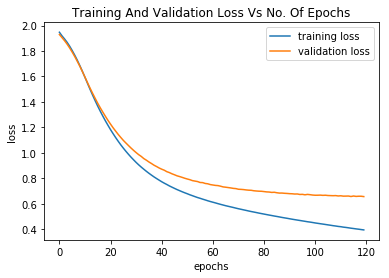

In [90]:
# Loss vs number of epochs with train and val set
plt.plot(model_val_dict['loss'], label='training loss')
plt.plot(model_val_dict['val_loss'], label='validation loss')
plt.title('training and validation loss vs no. of epochs'.title())
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

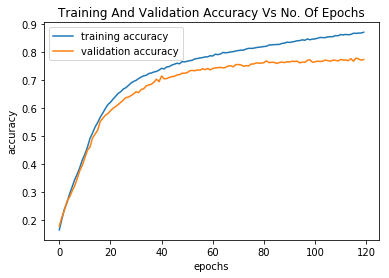

In [92]:
# Accuracy vs number of epochs with train and val set
plt.plot(model_val_dict['accuracy'], label='training accuracy')
plt.plot(model_val_dict['val_accuracy'], label='validation accuracy')
plt.title('training and validation accuracy vs no. of epochs'.title())
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Notice an interesting pattern here: although the training accuracy keeps increasing when going through more epochs, and the training loss keeps decreasing, the validation accuracy and loss seem to be reaching a limit around the 60th epoch. This means that you're probably **overfitting** the model to the training data when you train for many epochs past this dropoff point of around 40 epochs. Luckily, you learned how to tackle overfitting in the previous lecture! Since it seems clear that you are training too long, include early stopping at the 60th epoch first.

## Early Stopping

Below, observe how to update the model to include an earlier cutoff point:

In [95]:
import random
random.seed(123)
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(Dense(25, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model = model.fit(X_train_final,
                    y_train_final,
                    epochs=60,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 6500 samples, validate on 1000 samples
Epoch 1/60
6500/6500 [==============================] - 0s 35us/step - loss: 1.9530 - accuracy: 0.1335 - val_loss: 1.9415 - val_accuracy: 0.1500
Epoch 2/60
6500/6500 [==============================] - 0s 28us/step - loss: 1.9354 - accuracy: 0.1606 - val_loss: 1.9271 - val_accuracy: 0.1620
Epoch 3/60
6500/6500 [==============================] - 0s 27us/step - loss: 1.9200 - accuracy: 0.1851 - val_loss: 1.9125 - val_accuracy: 0.1980
Epoch 4/60
6500/6500 [==============================] - 0s 27us/step - loss: 1.9044 - accuracy: 0.1974 - val_loss: 1.8973 - val_accuracy: 0.2160
Epoch 5/60
6500/6500 [==============================] - 0s 27us/step - loss: 1.8876 - accuracy: 0.2157 - val_loss: 1.8804 - val_accuracy: 0.2490
Epoch 6/60
6500/6500 [==============================] - 0s 27us/step - loss: 1.8698 - accuracy: 0.2263 - val_loss: 1.8629 - val_accuracy: 0.2570
Epoch 7/60
6500/6500 [==============================] - 0s 27us/step - loss: 1.851

Epoch 57/60
6500/6500 [==============================] - 0s 28us/step - loss: 0.6279 - accuracy: 0.7832 - val_loss: 0.7157 - val_accuracy: 0.7450
Epoch 58/60
6500/6500 [==============================] - 0s 28us/step - loss: 0.6213 - accuracy: 0.7835 - val_loss: 0.7097 - val_accuracy: 0.7440
Epoch 59/60
6500/6500 [==============================] - 0s 26us/step - loss: 0.6152 - accuracy: 0.7866 - val_loss: 0.7049 - val_accuracy: 0.7470
Epoch 60/60
6500/6500 [==============================] - 0s 27us/step - loss: 0.6090 - accuracy: 0.7883 - val_loss: 0.6999 - val_accuracy: 0.7490


Now, you can use the test set to make label predictions

In [96]:
results_train = model.evaluate(X_train_final, y_train_final)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_tok, y_test_cat)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')

6500/6500 [==============================] - 0s 23us/step
Training Loss: 0.604 Training Accuracy: 0.791
2500/2500 [==============================] - 0s 22us/step
Testing Loss: 0.729 Testing Accuracy: 0.727


We've significantly reduced the variance, so this is already pretty good! your test set accuracy is slightly worse, but this model will definitely be more robust than the 120 epochs model you originally fit.

Now, take a look at how regularization techniques can further improve your model performance.

## L2 Regularization

First, take a look at L2 regularization. Keras makes L2 regularization easy. Simply add the `kernel_regularizer=keras.regularizers.l2(lambda_coeff)` parameter to any model layer. The `lambda_coeff` parameter determines the strength of the regularization you wish to perform.

In [97]:
from keras import regularizers
random.seed(123)
model = Sequential()
model.add(Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.005), input_shape=(2000,))) #2 hidden layers
model.add(Dense(25, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L2_model = model.fit(X_train_final,
                    y_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 6500 samples, validate on 1000 samples
Epoch 1/120
6500/6500 [==============================] - 0s 37us/step - loss: 2.5850 - accuracy: 0.1971 - val_loss: 2.5683 - val_accuracy: 0.2150
Epoch 2/120
6500/6500 [==============================] - 0s 28us/step - loss: 2.5671 - accuracy: 0.2149 - val_loss: 2.5507 - val_accuracy: 0.2270
Epoch 3/120
6500/6500 [==============================] - 0s 28us/step - loss: 2.5491 - accuracy: 0.2343 - val_loss: 2.5324 - val_accuracy: 0.2440
Epoch 4/120
6500/6500 [==============================] - 0s 29us/step - loss: 2.5299 - accuracy: 0.2478 - val_loss: 2.5126 - val_accuracy: 0.2600
Epoch 5/120
6500/6500 [==============================] - 0s 28us/step - loss: 2.5084 - accuracy: 0.2663 - val_loss: 2.4905 - val_accuracy: 0.2830
Epoch 6/120
6500/6500 [==============================] - 0s 27us/step - loss: 2.4843 - accuracy: 0.2840 - val_loss: 2.4656 - val_accuracy: 0.3010
Epoch 7/120
6500/6500 [==============================] - 0s 27us/step - loss

6500/6500 [==============================] - 0s 29us/step - loss: 1.2772 - accuracy: 0.7682 - val_loss: 1.3637 - val_accuracy: 0.7270
Epoch 57/120
6500/6500 [==============================] - 0s 27us/step - loss: 1.2676 - accuracy: 0.7682 - val_loss: 1.3567 - val_accuracy: 0.7340
Epoch 58/120
6500/6500 [==============================] - 0s 30us/step - loss: 1.2579 - accuracy: 0.7717 - val_loss: 1.3510 - val_accuracy: 0.7340
Epoch 59/120
6500/6500 [==============================] - 0s 28us/step - loss: 1.2493 - accuracy: 0.7725 - val_loss: 1.3424 - val_accuracy: 0.7350
Epoch 60/120
6500/6500 [==============================] - 0s 28us/step - loss: 1.2402 - accuracy: 0.7749 - val_loss: 1.3334 - val_accuracy: 0.7370
Epoch 61/120
6500/6500 [==============================] - 0s 27us/step - loss: 1.2311 - accuracy: 0.7760 - val_loss: 1.3268 - val_accuracy: 0.7380
Epoch 62/120
6500/6500 [==============================] - 0s 27us/step - loss: 1.2226 - accuracy: 0.7812 - val_loss: 1.3201 - val_a

Epoch 112/120
6500/6500 [==============================] - 0s 32us/step - loss: 0.9397 - accuracy: 0.8591 - val_loss: 1.1242 - val_accuracy: 0.7700
Epoch 113/120
6500/6500 [==============================] - 0s 31us/step - loss: 0.9361 - accuracy: 0.8606 - val_loss: 1.1216 - val_accuracy: 0.7690
Epoch 114/120
6500/6500 [==============================] - 0s 30us/step - loss: 0.9318 - accuracy: 0.8632 - val_loss: 1.1233 - val_accuracy: 0.7700
Epoch 115/120
6500/6500 [==============================] - 0s 31us/step - loss: 0.9282 - accuracy: 0.8615 - val_loss: 1.1163 - val_accuracy: 0.7680
Epoch 116/120
6500/6500 [==============================] - 0s 31us/step - loss: 0.9240 - accuracy: 0.8646 - val_loss: 1.1160 - val_accuracy: 0.7710
Epoch 117/120
6500/6500 [==============================] - 0s 36us/step - loss: 0.9199 - accuracy: 0.8655 - val_loss: 1.1154 - val_accuracy: 0.7730
Epoch 118/120
6500/6500 [==============================] - 0s 32us/step - loss: 0.9162 - accuracy: 0.8655 - val_

In [98]:
L2_model_dict = L2_model.history
L2_model_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

Now, look at the training accuracy as well as the validation accuracy for both the L2 and the model without regularization (for 120 epochs).

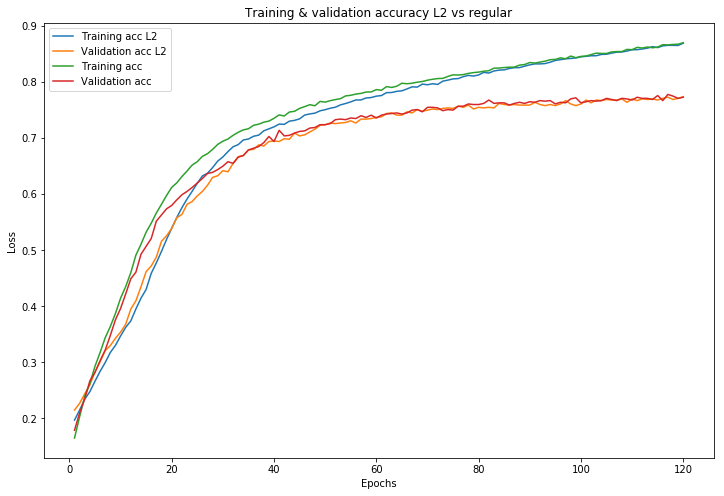

In [99]:
fig, ax = plt.subplots(figsize=(12, 8))

acc_values = L2_model_dict['accuracy'] 
val_acc_values = L2_model_dict['val_accuracy']

model_acc = model_val_dict['accuracy']
model_val_acc = model_val_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L2')
ax.plot(epochs, val_acc_values, label='Validation acc L2')
ax.plot(epochs, model_acc, label='Training acc')
ax.plot(epochs, model_val_acc, label='Validation acc')
ax.set_title('Training & validation accuracy L2 vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

The results of L2 regularization are quite disappointing here. Notice the discrepancy between validation and training accuracy seems to have decreased slightly, but the end result is definitely not getting better. 

## L1 Regularization

Have a look at L1 regularization. Will this work better?

In [101]:
random.seed(123)
model = Sequential()
model.add(Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(X_train_final,
                    y_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 6500 samples, validate on 1000 samples
Epoch 1/120
6500/6500 [==============================] - 0s 38us/step - loss: 16.0355 - accuracy: 0.1535 - val_loss: 15.6702 - val_accuracy: 0.1890
Epoch 2/120
6500/6500 [==============================] - 0s 28us/step - loss: 15.3720 - accuracy: 0.1834 - val_loss: 15.0207 - val_accuracy: 0.2120
Epoch 3/120
6500/6500 [==============================] - 0s 27us/step - loss: 14.7301 - accuracy: 0.1988 - val_loss: 14.3891 - val_accuracy: 0.2180
Epoch 4/120
6500/6500 [==============================] - 0s 27us/step - loss: 14.1060 - accuracy: 0.2043 - val_loss: 13.7746 - val_accuracy: 0.2170
Epoch 5/120
6500/6500 [==============================] - 0s 28us/step - loss: 13.4985 - accuracy: 0.2058 - val_loss: 13.1770 - val_accuracy: 0.2200
Epoch 6/120
6500/6500 [==============================] - 0s 28us/step - loss: 12.9075 - accuracy: 0.2118 - val_loss: 12.5951 - val_accuracy: 0.2240
Epoch 7/120
6500/6500 [==============================] - 0s 29us

6500/6500 [==============================] - 0s 27us/step - loss: 1.8553 - accuracy: 0.6569 - val_loss: 1.8787 - val_accuracy: 0.6450
Epoch 57/120
6500/6500 [==============================] - 0s 27us/step - loss: 1.8431 - accuracy: 0.6562 - val_loss: 1.8654 - val_accuracy: 0.6500
Epoch 58/120
6500/6500 [==============================] - 0s 29us/step - loss: 1.8314 - accuracy: 0.6578 - val_loss: 1.8534 - val_accuracy: 0.6490
Epoch 59/120
6500/6500 [==============================] - 0s 31us/step - loss: 1.8199 - accuracy: 0.6578 - val_loss: 1.8409 - val_accuracy: 0.6490
Epoch 60/120
6500/6500 [==============================] - 0s 30us/step - loss: 1.8082 - accuracy: 0.6588 - val_loss: 1.8345 - val_accuracy: 0.6570
Epoch 61/120
6500/6500 [==============================] - 0s 31us/step - loss: 1.7982 - accuracy: 0.6589 - val_loss: 1.8219 - val_accuracy: 0.6550
Epoch 62/120
6500/6500 [==============================] - 0s 28us/step - loss: 1.7875 - accuracy: 0.6623 - val_loss: 1.8101 - val_a

6500/6500 [==============================] - 0s 28us/step - loss: 1.4375 - accuracy: 0.6955 - val_loss: 1.4522 - val_accuracy: 0.7010
Epoch 112/120
6500/6500 [==============================] - 0s 27us/step - loss: 1.4317 - accuracy: 0.6963 - val_loss: 1.4397 - val_accuracy: 0.6980
Epoch 113/120
6500/6500 [==============================] - 0s 27us/step - loss: 1.4268 - accuracy: 0.6968 - val_loss: 1.4378 - val_accuracy: 0.6970
Epoch 114/120
6500/6500 [==============================] - 0s 28us/step - loss: 1.4218 - accuracy: 0.6966 - val_loss: 1.4310 - val_accuracy: 0.6990
Epoch 115/120
6500/6500 [==============================] - 0s 29us/step - loss: 1.4161 - accuracy: 0.6969 - val_loss: 1.4271 - val_accuracy: 0.6990
Epoch 116/120
6500/6500 [==============================] - 0s 31us/step - loss: 1.4112 - accuracy: 0.6991 - val_loss: 1.4203 - val_accuracy: 0.6960
Epoch 117/120
6500/6500 [==============================] - 0s 31us/step - loss: 1.4064 - accuracy: 0.6977 - val_loss: 1.4162 -

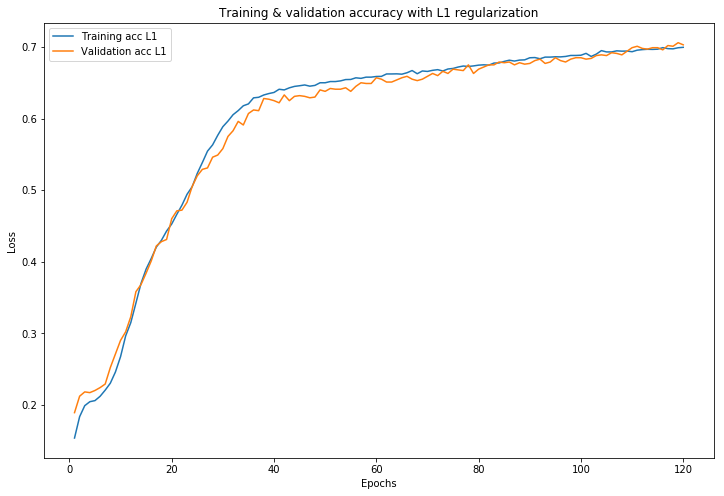

In [102]:
fig, ax = plt.subplots(figsize=(12, 8))

L1_model_dict = L1_model.history

acc_values = L1_model_dict['accuracy'] 
val_acc_values = L1_model_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L1')
ax.plot(epochs, val_acc_values, label='Validation acc L1')
ax.set_title('Training & validation accuracy with L1 regularization')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

Notice how the training and validation accuracy don't diverge as much as before. Unfortunately, the validation accuracy doesn't reach rates much higher than 70%. It does seem like you can still improve the model by training much longer.

In [104]:
# ⏰ This cell may take several minutes to run
random.seed(123)
model = Sequential()
model.add(Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(X_train_final,
                    y_train_final,
                    epochs=1000,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 6500 samples, validate on 1000 samples
Epoch 1/1000
6500/6500 [==============================] - 0s 42us/step - loss: 16.0427 - accuracy: 0.1400 - val_loss: 15.6799 - val_accuracy: 0.1740
Epoch 2/1000
6500/6500 [==============================] - 0s 27us/step - loss: 15.3781 - accuracy: 0.1803 - val_loss: 15.0273 - val_accuracy: 0.2060
Epoch 3/1000
6500/6500 [==============================] - 0s 27us/step - loss: 14.7348 - accuracy: 0.2015 - val_loss: 14.3940 - val_accuracy: 0.2150
Epoch 4/1000
6500/6500 [==============================] - 0s 29us/step - loss: 14.1097 - accuracy: 0.2117 - val_loss: 13.7783 - val_accuracy: 0.2290
Epoch 5/1000
6500/6500 [==============================] - 0s 27us/step - loss: 13.5010 - accuracy: 0.2168 - val_loss: 13.1788 - val_accuracy: 0.2380
Epoch 6/1000
6500/6500 [==============================] - 0s 29us/step - loss: 12.9072 - accuracy: 0.2271 - val_loss: 12.5944 - val_accuracy: 0.2450
Epoch 7/1000
6500/6500 [==============================] - 

Epoch 56/1000
6500/6500 [==============================] - 0s 30us/step - loss: 1.8961 - accuracy: 0.6758 - val_loss: 1.9133 - val_accuracy: 0.6750
Epoch 57/1000
6500/6500 [==============================] - 0s 28us/step - loss: 1.8836 - accuracy: 0.6755 - val_loss: 1.8999 - val_accuracy: 0.6710
Epoch 58/1000
6500/6500 [==============================] - 0s 28us/step - loss: 1.8715 - accuracy: 0.6762 - val_loss: 1.8891 - val_accuracy: 0.6720
Epoch 59/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.8600 - accuracy: 0.6772 - val_loss: 1.8774 - val_accuracy: 0.6840
Epoch 60/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.8484 - accuracy: 0.6794 - val_loss: 1.8650 - val_accuracy: 0.6850
Epoch 61/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.8371 - accuracy: 0.6811 - val_loss: 1.8551 - val_accuracy: 0.6850
Epoch 62/1000
6500/6500 [==============================] - 0s 28us/step - loss: 1.8266 - accuracy: 0.6769 - val_

Epoch 111/1000
6500/6500 [==============================] - 0s 28us/step - loss: 1.4657 - accuracy: 0.7018 - val_loss: 1.4780 - val_accuracy: 0.7060
Epoch 112/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.4599 - accuracy: 0.7037 - val_loss: 1.4769 - val_accuracy: 0.7050
Epoch 113/1000
6500/6500 [==============================] - 0s 35us/step - loss: 1.4552 - accuracy: 0.7023 - val_loss: 1.4668 - val_accuracy: 0.7060
Epoch 114/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.4491 - accuracy: 0.7042 - val_loss: 1.4633 - val_accuracy: 0.7070
Epoch 115/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.4436 - accuracy: 0.7042 - val_loss: 1.4561 - val_accuracy: 0.7100
Epoch 116/1000
6500/6500 [==============================] - 0s 28us/step - loss: 1.4387 - accuracy: 0.7048 - val_loss: 1.4571 - val_accuracy: 0.7140
Epoch 117/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.4334 - accuracy: 0.7018

Epoch 166/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.2312 - accuracy: 0.7209 - val_loss: 1.2398 - val_accuracy: 0.7340
Epoch 167/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.2273 - accuracy: 0.7208 - val_loss: 1.2379 - val_accuracy: 0.7350
Epoch 168/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.2243 - accuracy: 0.7222 - val_loss: 1.2328 - val_accuracy: 0.7360
Epoch 169/1000
6500/6500 [==============================] - 0s 32us/step - loss: 1.2214 - accuracy: 0.7209 - val_loss: 1.2311 - val_accuracy: 0.7350
Epoch 170/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.2186 - accuracy: 0.7205 - val_loss: 1.2271 - val_accuracy: 0.7400
Epoch 171/1000
6500/6500 [==============================] - 0s 28us/step - loss: 1.2154 - accuracy: 0.7220 - val_loss: 1.2248 - val_accuracy: 0.7330
Epoch 172/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.2127 - accuracy: 0.7235

Epoch 221/1000
6500/6500 [==============================] - 0s 28us/step - loss: 1.1074 - accuracy: 0.7371 - val_loss: 1.1168 - val_accuracy: 0.7430
Epoch 222/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.1071 - accuracy: 0.7391 - val_loss: 1.1160 - val_accuracy: 0.7500
Epoch 223/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.1049 - accuracy: 0.7377 - val_loss: 1.1139 - val_accuracy: 0.7440
Epoch 224/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.1035 - accuracy: 0.7383 - val_loss: 1.1109 - val_accuracy: 0.7460
Epoch 225/1000
6500/6500 [==============================] - 0s 32us/step - loss: 1.1020 - accuracy: 0.7386 - val_loss: 1.1140 - val_accuracy: 0.7430
Epoch 226/1000
6500/6500 [==============================] - 0s 28us/step - loss: 1.1007 - accuracy: 0.7391 - val_loss: 1.1123 - val_accuracy: 0.7440
Epoch 227/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.0995 - accuracy: 0.7383

Epoch 276/1000
6500/6500 [==============================] - 0s 28us/step - loss: 1.0429 - accuracy: 0.7478 - val_loss: 1.0564 - val_accuracy: 0.7530
Epoch 277/1000
6500/6500 [==============================] - 0s 28us/step - loss: 1.0417 - accuracy: 0.7480 - val_loss: 1.0550 - val_accuracy: 0.7530
Epoch 278/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.0409 - accuracy: 0.7475 - val_loss: 1.0601 - val_accuracy: 0.7590
Epoch 279/1000
6500/6500 [==============================] - 0s 30us/step - loss: 1.0407 - accuracy: 0.7480 - val_loss: 1.0524 - val_accuracy: 0.7590
Epoch 280/1000
6500/6500 [==============================] - 0s 30us/step - loss: 1.0390 - accuracy: 0.7515 - val_loss: 1.0522 - val_accuracy: 0.7550
Epoch 281/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.0385 - accuracy: 0.7489 - val_loss: 1.0518 - val_accuracy: 0.7530
Epoch 282/1000
6500/6500 [==============================] - 0s 27us/step - loss: 1.0367 - accuracy: 0.7503

Epoch 331/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.9978 - accuracy: 0.7591 - val_loss: 1.0177 - val_accuracy: 0.7610
Epoch 332/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.9964 - accuracy: 0.7572 - val_loss: 1.0151 - val_accuracy: 0.7630
Epoch 333/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.9963 - accuracy: 0.7609 - val_loss: 1.0192 - val_accuracy: 0.7550
Epoch 334/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.9959 - accuracy: 0.7577 - val_loss: 1.0149 - val_accuracy: 0.7610
Epoch 335/1000
6500/6500 [==============================] - 0s 36us/step - loss: 0.9947 - accuracy: 0.7592 - val_loss: 1.0136 - val_accuracy: 0.7610
Epoch 336/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.9938 - accuracy: 0.7563 - val_loss: 1.0203 - val_accuracy: 0.7580
Epoch 337/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.9939 - accuracy: 0.7597

Epoch 386/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.9639 - accuracy: 0.7680 - val_loss: 0.9894 - val_accuracy: 0.7650
Epoch 387/1000
6500/6500 [==============================] - 0s 29us/step - loss: 0.9642 - accuracy: 0.7662 - val_loss: 0.9934 - val_accuracy: 0.7610
Epoch 388/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.9636 - accuracy: 0.7655 - val_loss: 0.9927 - val_accuracy: 0.7620
Epoch 389/1000
6500/6500 [==============================] - ETA: 0s - loss: 0.9512 - accuracy: 0.76 - 0s 28us/step - loss: 0.9629 - accuracy: 0.7665 - val_loss: 0.9894 - val_accuracy: 0.7630
Epoch 390/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.9613 - accuracy: 0.7654 - val_loss: 0.9866 - val_accuracy: 0.7600
Epoch 391/1000
6500/6500 [==============================] - 0s 31us/step - loss: 0.9611 - accuracy: 0.7678 - val_loss: 0.9846 - val_accuracy: 0.7590
Epoch 392/1000
6500/6500 [==============================] - 0s 2

6500/6500 [==============================] - 0s 30us/step - loss: 0.9383 - accuracy: 0.7717 - val_loss: 0.9830 - val_accuracy: 0.7590
Epoch 441/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.9385 - accuracy: 0.7731 - val_loss: 0.9734 - val_accuracy: 0.7640
Epoch 442/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.9367 - accuracy: 0.7729 - val_loss: 0.9716 - val_accuracy: 0.7680
Epoch 443/1000
6500/6500 [==============================] - 0s 29us/step - loss: 0.9372 - accuracy: 0.7731 - val_loss: 0.9669 - val_accuracy: 0.7620
Epoch 444/1000
6500/6500 [==============================] - 0s 29us/step - loss: 0.9363 - accuracy: 0.7714 - val_loss: 0.9780 - val_accuracy: 0.7670
Epoch 445/1000
6500/6500 [==============================] - 0s 30us/step - loss: 0.9346 - accuracy: 0.7728 - val_loss: 0.9741 - val_accuracy: 0.7630
Epoch 446/1000
6500/6500 [==============================] - 0s 36us/step - loss: 0.9336 - accuracy: 0.7712 - val_loss: 0.

Epoch 495/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.9150 - accuracy: 0.7806 - val_loss: 0.9555 - val_accuracy: 0.7690
Epoch 496/1000
6500/6500 [==============================] - 0s 29us/step - loss: 0.9154 - accuracy: 0.7769 - val_loss: 0.9617 - val_accuracy: 0.7620
Epoch 497/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.9141 - accuracy: 0.7800 - val_loss: 0.9622 - val_accuracy: 0.7590
Epoch 498/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.9157 - accuracy: 0.7768 - val_loss: 0.9597 - val_accuracy: 0.7660
Epoch 499/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.9128 - accuracy: 0.7800 - val_loss: 0.9622 - val_accuracy: 0.7640
Epoch 500/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.9143 - accuracy: 0.7772 - val_loss: 0.9665 - val_accuracy: 0.7590
Epoch 501/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.9136 - accuracy: 0.7786

Epoch 550/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8958 - accuracy: 0.7842 - val_loss: 0.9584 - val_accuracy: 0.7580
Epoch 551/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8965 - accuracy: 0.7814 - val_loss: 0.9359 - val_accuracy: 0.7690
Epoch 552/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8950 - accuracy: 0.7806 - val_loss: 0.9375 - val_accuracy: 0.7750
Epoch 553/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8948 - accuracy: 0.7825 - val_loss: 0.9435 - val_accuracy: 0.7660
Epoch 554/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8953 - accuracy: 0.7829 - val_loss: 0.9368 - val_accuracy: 0.7700
Epoch 555/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8941 - accuracy: 0.7815 - val_loss: 0.9369 - val_accuracy: 0.7730
Epoch 556/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8934 - accuracy: 0.7855

6500/6500 [==============================] - 0s 27us/step - loss: 0.8784 - accuracy: 0.7863 - val_loss: 0.9459 - val_accuracy: 0.7650
Epoch 605/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8788 - accuracy: 0.7888 - val_loss: 0.9362 - val_accuracy: 0.7740
Epoch 606/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8784 - accuracy: 0.7860 - val_loss: 0.9269 - val_accuracy: 0.7730
Epoch 607/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8769 - accuracy: 0.7865 - val_loss: 0.9330 - val_accuracy: 0.7670
Epoch 608/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8760 - accuracy: 0.7894 - val_loss: 0.9287 - val_accuracy: 0.7760
Epoch 609/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8777 - accuracy: 0.7886 - val_loss: 0.9343 - val_accuracy: 0.7700
Epoch 610/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8776 - accuracy: 0.7863 - val_loss: 0.

6500/6500 [==============================] - 0s 27us/step - loss: 0.8653 - accuracy: 0.7914 - val_loss: 0.9326 - val_accuracy: 0.7660
Epoch 660/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8658 - accuracy: 0.7888 - val_loss: 0.9209 - val_accuracy: 0.7800
Epoch 661/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8653 - accuracy: 0.7900 - val_loss: 0.9201 - val_accuracy: 0.7760
Epoch 662/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8627 - accuracy: 0.7922 - val_loss: 0.9340 - val_accuracy: 0.7640
Epoch 663/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8658 - accuracy: 0.7892 - val_loss: 0.9536 - val_accuracy: 0.7530
Epoch 664/1000
6500/6500 [==============================] - 0s 29us/step - loss: 0.8659 - accuracy: 0.7912 - val_loss: 0.9305 - val_accuracy: 0.7620
Epoch 665/1000
6500/6500 [==============================] - 0s 30us/step - loss: 0.8640 - accuracy: 0.7925 - val_loss: 0.

6500/6500 [==============================] - 0s 28us/step - loss: 0.8529 - accuracy: 0.7969 - val_loss: 0.9121 - val_accuracy: 0.7730
Epoch 714/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8566 - accuracy: 0.7954 - val_loss: 0.9172 - val_accuracy: 0.7770
Epoch 715/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8520 - accuracy: 0.7955 - val_loss: 0.9501 - val_accuracy: 0.7600
Epoch 716/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8535 - accuracy: 0.7951 - val_loss: 0.9210 - val_accuracy: 0.7710
Epoch 717/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8537 - accuracy: 0.7937 - val_loss: 0.9172 - val_accuracy: 0.7770
Epoch 718/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8515 - accuracy: 0.7975 - val_loss: 0.9220 - val_accuracy: 0.7760
Epoch 719/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8546 - accuracy: 0.7952 - val_loss: 0.

Epoch 768/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8420 - accuracy: 0.8035 - val_loss: 0.9146 - val_accuracy: 0.7670
Epoch 769/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8401 - accuracy: 0.8005 - val_loss: 0.9191 - val_accuracy: 0.7690
Epoch 770/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8396 - accuracy: 0.8008 - val_loss: 0.9108 - val_accuracy: 0.7740
Epoch 771/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8402 - accuracy: 0.7986 - val_loss: 0.9397 - val_accuracy: 0.7570
Epoch 772/1000
6500/6500 [==============================] - 0s 29us/step - loss: 0.8435 - accuracy: 0.7998 - val_loss: 0.9116 - val_accuracy: 0.7770
Epoch 773/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8401 - accuracy: 0.8005 - val_loss: 0.9092 - val_accuracy: 0.7780
Epoch 774/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8401 - accuracy: 0.8005

Epoch 823/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8295 - accuracy: 0.8028 - val_loss: 0.9157 - val_accuracy: 0.7670
Epoch 824/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8290 - accuracy: 0.8077 - val_loss: 0.9085 - val_accuracy: 0.7730
Epoch 825/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8329 - accuracy: 0.8032 - val_loss: 0.9276 - val_accuracy: 0.7750
Epoch 826/1000
6500/6500 [==============================] - ETA: 0s - loss: 0.8308 - accuracy: 0.80 - 0s 28us/step - loss: 0.8331 - accuracy: 0.8017 - val_loss: 0.9044 - val_accuracy: 0.7680
Epoch 827/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8284 - accuracy: 0.8054 - val_loss: 0.9068 - val_accuracy: 0.7780
Epoch 828/1000
6500/6500 [==============================] - 0s 29us/step - loss: 0.8296 - accuracy: 0.8062 - val_loss: 0.9100 - val_accuracy: 0.7720
Epoch 829/1000
6500/6500 [==============================] - 0s 2

Epoch 878/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8162 - accuracy: 0.8122 - val_loss: 0.9104 - val_accuracy: 0.7730
Epoch 879/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8234 - accuracy: 0.8100 - val_loss: 0.9059 - val_accuracy: 0.7820
Epoch 880/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8224 - accuracy: 0.8109 - val_loss: 0.9127 - val_accuracy: 0.7840
Epoch 881/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8176 - accuracy: 0.8085 - val_loss: 0.9053 - val_accuracy: 0.7810
Epoch 882/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8214 - accuracy: 0.8102 - val_loss: 0.9266 - val_accuracy: 0.7650
Epoch 883/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8242 - accuracy: 0.8054 - val_loss: 0.9174 - val_accuracy: 0.7800
Epoch 884/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8219 - accuracy: 0.8034

Epoch 933/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8100 - accuracy: 0.8157 - val_loss: 0.9159 - val_accuracy: 0.7720
Epoch 934/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8162 - accuracy: 0.8097 - val_loss: 0.9135 - val_accuracy: 0.7840
Epoch 935/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8199 - accuracy: 0.8106 - val_loss: 0.9061 - val_accuracy: 0.7820
Epoch 936/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8104 - accuracy: 0.8137 - val_loss: 0.9219 - val_accuracy: 0.7800
Epoch 937/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8136 - accuracy: 0.8129 - val_loss: 0.9031 - val_accuracy: 0.7790
Epoch 938/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8058 - accuracy: 0.8142 - val_loss: 0.9515 - val_accuracy: 0.7550
Epoch 939/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8210 - accuracy: 0.8102

6500/6500 [==============================] - 0s 27us/step - loss: 0.8051 - accuracy: 0.8168 - val_loss: 0.9212 - val_accuracy: 0.7740
Epoch 988/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.7994 - accuracy: 0.8195 - val_loss: 0.9894 - val_accuracy: 0.7570
Epoch 989/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8020 - accuracy: 0.8197 - val_loss: 0.9286 - val_accuracy: 0.7560
Epoch 990/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8241 - accuracy: 0.8098 - val_loss: 0.9867 - val_accuracy: 0.7450
Epoch 991/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8058 - accuracy: 0.8182 - val_loss: 0.9142 - val_accuracy: 0.7840
Epoch 992/1000
6500/6500 [==============================] - 0s 27us/step - loss: 0.8044 - accuracy: 0.8180 - val_loss: 0.9200 - val_accuracy: 0.7830
Epoch 993/1000
6500/6500 [==============================] - 0s 28us/step - loss: 0.8095 - accuracy: 0.8138 - val_loss: 0.

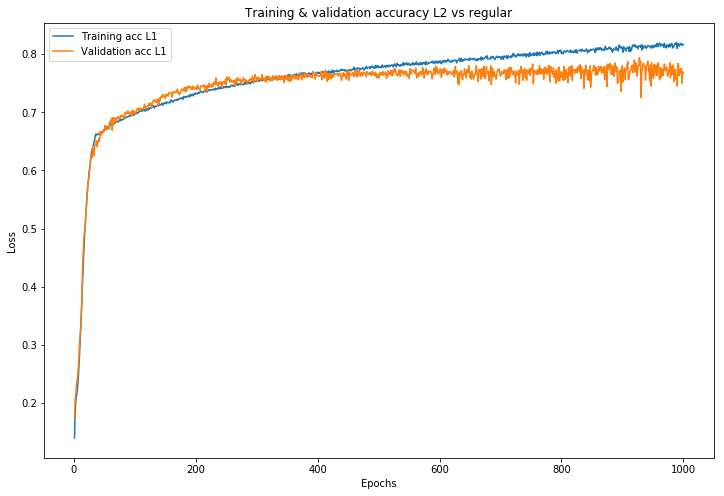

In [105]:
fig, ax = plt.subplots(figsize=(12, 8))

L1_model_dict = L1_model.history

acc_values = L1_model_dict['accuracy'] 
val_acc_values = L1_model_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L1')
ax.plot(epochs, val_acc_values, label='Validation acc L1')
ax.set_title('Training & validation accuracy L2 vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

In [107]:
results_train = model.evaluate(X_train_final, y_train_final)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_tok, y_test_cat)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')   

6500/6500 [==============================] - 0s 25us/step
Training Loss: 0.835 Training Accuracy: 0.808
2500/2500 [==============================] - 0s 24us/step
Testing Loss: 1.01 Testing Accuracy: 0.736


This is about the best result you've achieved so far, but you were training for quite a while! Next, experiment with dropout regularization to see if it offers any advantages.

## Dropout Regularization

In [109]:
X_train_tok, y_train_lb = X_train_final, y_train_final

In [111]:
# ⏰ This cell may take about a minute to run
from keras import layers
random.seed(123)
model = Sequential()
model.add(layers.Dropout(0.3, input_shape=(2000,)))
model.add(layers.Dense(50, activation='relu')) #2 hidden layers
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

dropout_model = model.fit(X_train_tok,
                    y_train_lb,
                    epochs=200,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 6500 samples, validate on 1000 samples
Epoch 1/200
6500/6500 [==============================] - 0s 61us/step - loss: 1.9973 - accuracy: 0.1531 - val_loss: 1.9330 - val_accuracy: 0.1490
Epoch 2/200
6500/6500 [==============================] - 0s 43us/step - loss: 1.9581 - accuracy: 0.1612 - val_loss: 1.9205 - val_accuracy: 0.1770
Epoch 3/200
6500/6500 [==============================] - 0s 44us/step - loss: 1.9422 - accuracy: 0.1709 - val_loss: 1.9119 - val_accuracy: 0.2120
Epoch 4/200
6500/6500 [==============================] - 0s 43us/step - loss: 1.9297 - accuracy: 0.1751 - val_loss: 1.9035 - val_accuracy: 0.2350
Epoch 5/200
6500/6500 [==============================] - 0s 43us/step - loss: 1.9208 - accuracy: 0.1828 - val_loss: 1.8946 - val_accuracy: 0.2550
Epoch 6/200
6500/6500 [==============================] - 0s 44us/step - loss: 1.9160 - accuracy: 0.1854 - val_loss: 1.8866 - val_accuracy: 0.2710
Epoch 7/200
6500/6500 [==============================] - 0s 46us/step - loss

6500/6500 [==============================] - 0s 45us/step - loss: 1.2739 - accuracy: 0.5189 - val_loss: 1.0742 - val_accuracy: 0.6590
Epoch 57/200
6500/6500 [==============================] - 0s 43us/step - loss: 1.2801 - accuracy: 0.5111 - val_loss: 1.0615 - val_accuracy: 0.6640
Epoch 58/200
6500/6500 [==============================] - 0s 44us/step - loss: 1.2501 - accuracy: 0.5302 - val_loss: 1.0525 - val_accuracy: 0.6680
Epoch 59/200
6500/6500 [==============================] - 0s 43us/step - loss: 1.2544 - accuracy: 0.5237 - val_loss: 1.0435 - val_accuracy: 0.6630
Epoch 60/200
6500/6500 [==============================] - 0s 44us/step - loss: 1.2464 - accuracy: 0.5248 - val_loss: 1.0329 - val_accuracy: 0.6690
Epoch 61/200
6500/6500 [==============================] - 0s 43us/step - loss: 1.2230 - accuracy: 0.5372 - val_loss: 1.0224 - val_accuracy: 0.6690
Epoch 62/200
6500/6500 [==============================] - 0s 43us/step - loss: 1.2300 - accuracy: 0.5348 - val_loss: 1.0119 - val_a

Epoch 112/200
6500/6500 [==============================] - 0s 44us/step - loss: 0.9591 - accuracy: 0.6377 - val_loss: 0.7442 - val_accuracy: 0.7560
Epoch 113/200
6500/6500 [==============================] - 0s 44us/step - loss: 0.9552 - accuracy: 0.6383 - val_loss: 0.7424 - val_accuracy: 0.7530
Epoch 114/200
6500/6500 [==============================] - 0s 46us/step - loss: 0.9350 - accuracy: 0.6532 - val_loss: 0.7397 - val_accuracy: 0.7530
Epoch 115/200
6500/6500 [==============================] - 0s 44us/step - loss: 0.9528 - accuracy: 0.6389 - val_loss: 0.7362 - val_accuracy: 0.7570
Epoch 116/200
6500/6500 [==============================] - 0s 44us/step - loss: 0.9398 - accuracy: 0.6502 - val_loss: 0.7322 - val_accuracy: 0.7570
Epoch 117/200
6500/6500 [==============================] - 0s 46us/step - loss: 0.9336 - accuracy: 0.6526 - val_loss: 0.7294 - val_accuracy: 0.7550
Epoch 118/200
6500/6500 [==============================] - 0s 45us/step - loss: 0.9391 - accuracy: 0.6531 - val_

6500/6500 [==============================] - 0s 46us/step - loss: 0.8166 - accuracy: 0.6954 - val_loss: 0.6448 - val_accuracy: 0.7660
Epoch 168/200
6500/6500 [==============================] - 0s 46us/step - loss: 0.8092 - accuracy: 0.7000 - val_loss: 0.6453 - val_accuracy: 0.7740
Epoch 169/200
6500/6500 [==============================] - 0s 47us/step - loss: 0.8196 - accuracy: 0.6966 - val_loss: 0.6450 - val_accuracy: 0.7710
Epoch 170/200
6500/6500 [==============================] - 0s 46us/step - loss: 0.8098 - accuracy: 0.6966 - val_loss: 0.6421 - val_accuracy: 0.7770
Epoch 171/200
6500/6500 [==============================] - 0s 46us/step - loss: 0.8228 - accuracy: 0.6952 - val_loss: 0.6435 - val_accuracy: 0.7720
Epoch 172/200
6500/6500 [==============================] - 0s 46us/step - loss: 0.7998 - accuracy: 0.6985 - val_loss: 0.6401 - val_accuracy: 0.7730
Epoch 173/200
6500/6500 [==============================] - 0s 46us/step - loss: 0.8073 - accuracy: 0.6934 - val_loss: 0.6394 -

In [112]:
results_train = model.evaluate(X_train_tok, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_tok, y_test_cat)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')   

6500/6500 [==============================] - 0s 26us/step
Training Loss: 0.475 Training Accuracy: 0.83
2500/2500 [==============================] - 0s 24us/step
Testing Loss: 0.645 Testing Accuracy: 0.762


You can see here that the validation performance has improved again! The variance did become higher again compared to L1-regularization.

## Bigger Data?

In the lecture, one of the solutions to high variance was just getting more data. You actually *have* more data, but took a subset of 10,000 units before. Let's now quadruple your data set, and see what happens. Note that you are really just lucky here, and getting more data isn't always possible, but this is a useful exercise in order to understand the power of big data sets.

In [113]:
df = pd.read_csv('Bank_complaints.csv')
df = df.sample(40000, random_state=123)

X = df["Consumer complaint narrative"]
y = df["Product"]

# train test split
X_train_lrg, X_test_lrg, y_train_lrg, y_test_lrg = train_test_split(X, y, random_state=42)

#Validation set
X_train_final_lrg, X_val_lrg, y_train_final_lrg, y_val_lrg = train_test_split(X_train_lrg, y_train_lrg, random_state=123)


#one-hot encoding of the complaints
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_train_final_lrg)

X_train_tok_lrg = tokenizer.texts_to_matrix(X_train_final_lrg, mode='binary')
X_val_lrg = tokenizer.texts_to_matrix(X_val_lrg, mode='binary')
X_test_lrg = tokenizer.texts_to_matrix(X_test_lrg, mode='binary')

#one-hot encoding of products
lb = LabelBinarizer()
lb.fit(y_train_final_lrg)

y_train_lb_lrg = to_categorical(lb.transform(y_train_final_lrg))[:, :, 1]
y_val_lrg = to_categorical(lb.transform(y_val_lrg))[:, :, 1]
y_test_lrg = to_categorical(lb.transform(y_test_lrg))[:, :, 1]

In [115]:
# ⏰ This cell may take several minutes to run
random.seed(123)
model = Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

moredata_model = model.fit(X_train_tok_lrg,
                    y_train_lb_lrg,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val_lrg, y_val_lrg))

Train on 22500 samples, validate on 7500 samples
Epoch 1/120
22500/22500 [==============================] - 1s 32us/step - loss: 1.9187 - accuracy: 0.1964 - val_loss: 1.8816 - val_accuracy: 0.2256
Epoch 2/120
22500/22500 [==============================] - 1s 30us/step - loss: 1.8450 - accuracy: 0.2499 - val_loss: 1.7990 - val_accuracy: 0.2853
Epoch 3/120
22500/22500 [==============================] - 1s 30us/step - loss: 1.7439 - accuracy: 0.3236 - val_loss: 1.6844 - val_accuracy: 0.3660
Epoch 4/120
22500/22500 [==============================] - 1s 31us/step - loss: 1.6134 - accuracy: 0.4134 - val_loss: 1.5455 - val_accuracy: 0.4555
Epoch 5/120
22500/22500 [==============================] - 1s 33us/step - loss: 1.4705 - accuracy: 0.4992 - val_loss: 1.4046 - val_accuracy: 0.5369
Epoch 6/120
22500/22500 [==============================] - 1s 31us/step - loss: 1.3331 - accuracy: 0.5694 - val_loss: 1.2738 - val_accuracy: 0.6064
Epoch 7/120
22500/22500 [==============================] - 1s 3

Epoch 56/120
22500/22500 [==============================] - 1s 31us/step - loss: 0.4258 - accuracy: 0.8517 - val_loss: 0.5765 - val_accuracy: 0.7911
Epoch 57/120
22500/22500 [==============================] - 1s 29us/step - loss: 0.4230 - accuracy: 0.8522 - val_loss: 0.5761 - val_accuracy: 0.7897
Epoch 58/120
22500/22500 [==============================] - 1s 29us/step - loss: 0.4194 - accuracy: 0.8537 - val_loss: 0.5764 - val_accuracy: 0.7905
Epoch 59/120
22500/22500 [==============================] - 1s 29us/step - loss: 0.4166 - accuracy: 0.8546 - val_loss: 0.5765 - val_accuracy: 0.7919
Epoch 60/120
22500/22500 [==============================] - 1s 29us/step - loss: 0.4135 - accuracy: 0.8564 - val_loss: 0.5772 - val_accuracy: 0.7904
Epoch 61/120
22500/22500 [==============================] - 1s 30us/step - loss: 0.4103 - accuracy: 0.8568 - val_loss: 0.5752 - val_accuracy: 0.7936
Epoch 62/120
22500/22500 [==============================] - 1s 29us/step - loss: 0.4078 - accuracy: 0.8576

22500/22500 [==============================] - 1s 29us/step - loss: 0.3069 - accuracy: 0.8970 - val_loss: 0.6062 - val_accuracy: 0.7935
Epoch 111/120
22500/22500 [==============================] - 1s 29us/step - loss: 0.3046 - accuracy: 0.8992 - val_loss: 0.6082 - val_accuracy: 0.7935
Epoch 112/120
22500/22500 [==============================] - 1s 29us/step - loss: 0.3036 - accuracy: 0.8990 - val_loss: 0.6070 - val_accuracy: 0.7925
Epoch 113/120
22500/22500 [==============================] - 1s 29us/step - loss: 0.3017 - accuracy: 0.8989 - val_loss: 0.6106 - val_accuracy: 0.7968
Epoch 114/120
22500/22500 [==============================] - 1s 29us/step - loss: 0.3005 - accuracy: 0.8987 - val_loss: 0.6179 - val_accuracy: 0.7940
Epoch 115/120
22500/22500 [==============================] - 1s 29us/step - loss: 0.2987 - accuracy: 0.8999 - val_loss: 0.6109 - val_accuracy: 0.7948
Epoch 116/120
22500/22500 [==============================] - 1s 29us/step - loss: 0.2975 - accuracy: 0.9009 - val_

In [116]:
results_train = model.evaluate(X_train_tok_lrg, y_train_lb_lrg)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_lrg, y_test_lrg)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')

22500/22500 [==============================] - 0s 21us/step
Training Loss: 0.286 Training Accuracy: 0.905
10000/10000 [==============================] - 0s 20us/step
Testing Loss: 0.616 Testing Accuracy: 0.792


With the same amount of epochs, you were able to get a fairly similar validation accuracy of 89.67 (compared to 88.45 in obtained in the first model in this lab). Your test set accuracy went up from 75.8 to 79.2% though, without any other regularization technique. You can still consider early stopping, L1, L2 and dropout here. It's clear that having more data has a strong impact on model performance!

## Additional Resources

* https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb
* https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
* https://catalog.data.gov/dataset/consumer-complaint-database

## Summary  

In this lesson, you not only built an initial deep-learning model, you then used a validation set to tune your model using various types of regularization.